# MMA 867 - Individual Assignment
## Kaggle Competition - House Prices - Advanced Regression Techniques
### By Gopala Goyal - 20254605

>As a part of this assignment, we would be performing predictive analysis on Housing price data from Kaggle and estimating the prices of houses in Iowa and other parts of the US where is the data is based on.

> The flow of the assignment would be
>1. Collecting, gathering and importing data
>2. Performing Exploratory Data Analysis (EDA) where we see what the data is and how it is structured, and check for any discrepancies in the data
>3. Data Wrangling Process - Clean, structure and prepare data for predictive analysis
>4. Developing regression model to predict housing prices for test data
>5. Reporting outcomes

In [1]:
#Import the required libraries
import pandas as pd
import numpy as np
import matplotlib as mplt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

In [2]:
hp_train_df = pd.read_csv("train.csv")
hp_test_df = pd.read_csv("test.csv")
hp_train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
hp_train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
hp_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
#Backup DataFrame
hp_tr = hp_train_df
hp_te= hp_test_df

##### We would use hp_tr as training data and hp_te as test data for this project
### Data exploration

/Users/apple/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


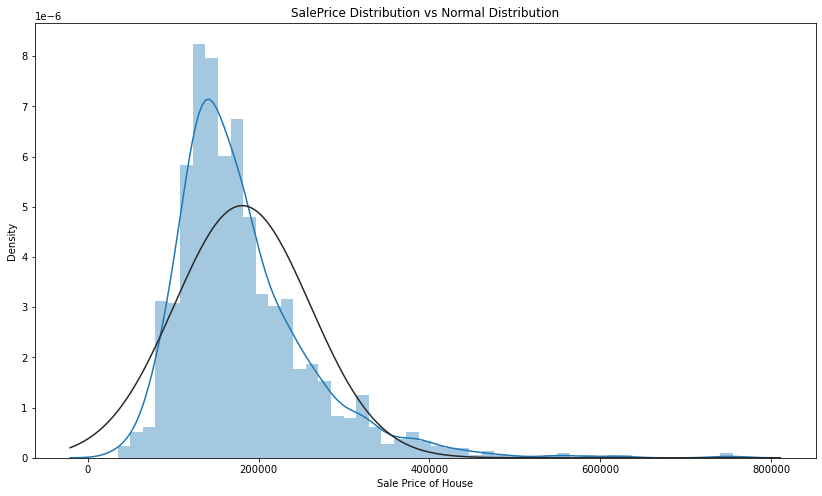

In [6]:
plt.figure(figsize = (14,8))
sns.distplot(hp_tr['SalePrice'], kde= True, hist=True, fit = norm)
plt.xlabel('Sale Price of House')
plt.title('SalePrice Distribution vs Normal Distribution')
plt.show()

<AxesSubplot:>

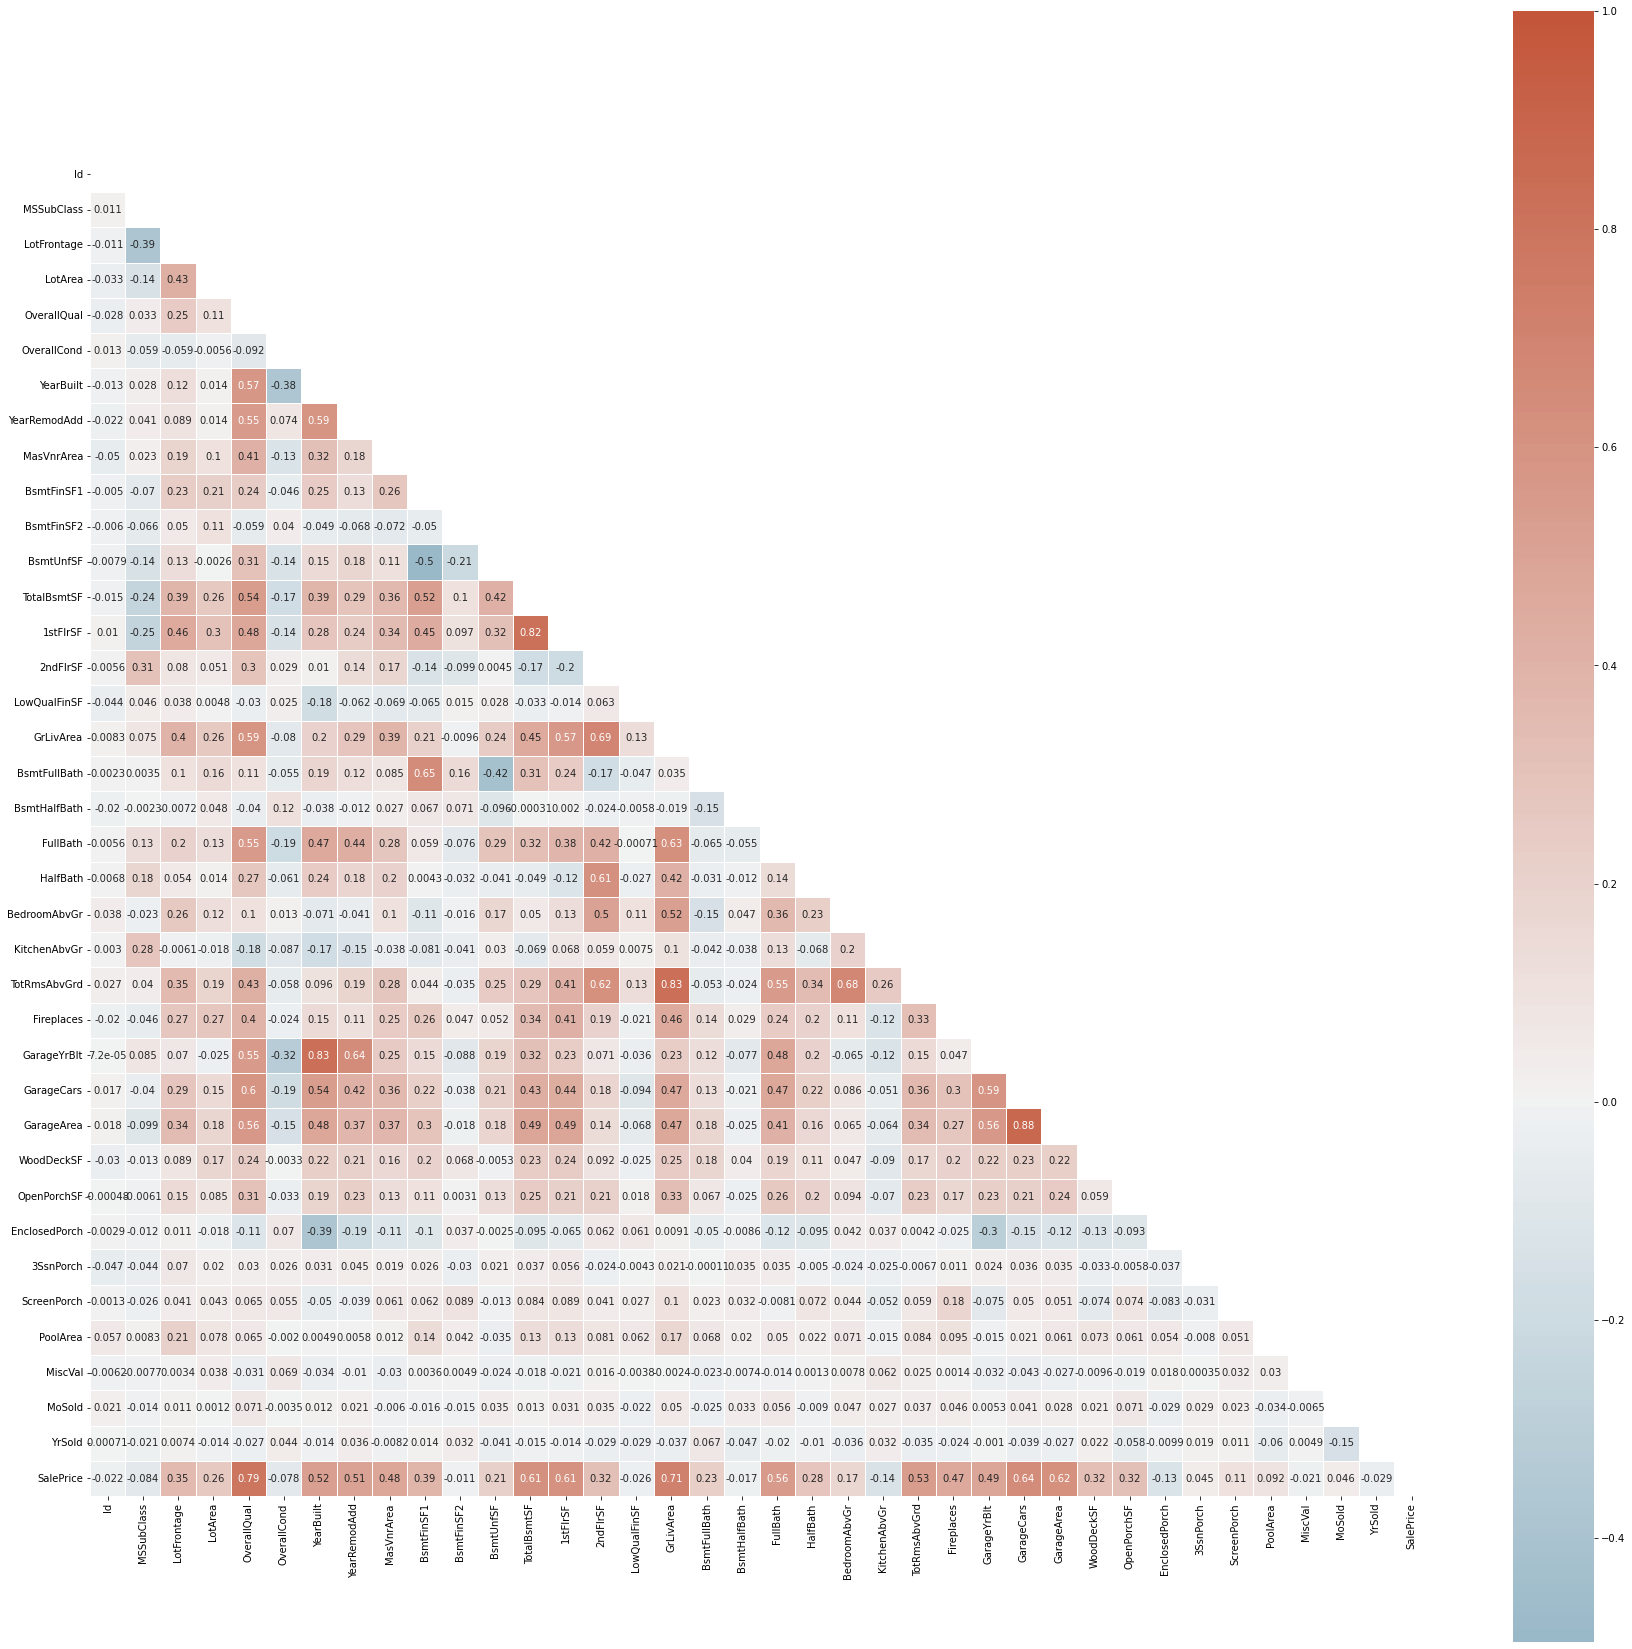

In [7]:
#Create a correlation matrix to see the correlation between independent variables and SalePrice
plt.figure(figsize = (30,30))
corr_matrix = hp_tr.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix,mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5)

In [8]:
signif_list = corr_matrix[corr_matrix['SalePrice']>0.5].all(axis = 1)
signif_list

OverallQual     True
YearBuilt       True
YearRemodAdd    True
TotalBsmtSF     True
1stFlrSF        True
GrLivArea       True
FullBath        True
TotRmsAbvGrd    True
GarageCars      True
GarageArea      True
SalePrice       True
dtype: bool

#### Since we have the list of variables that are highly correlated (>0.5) to the SalePrice target variable, we now explore more on their relation to the SalePrice

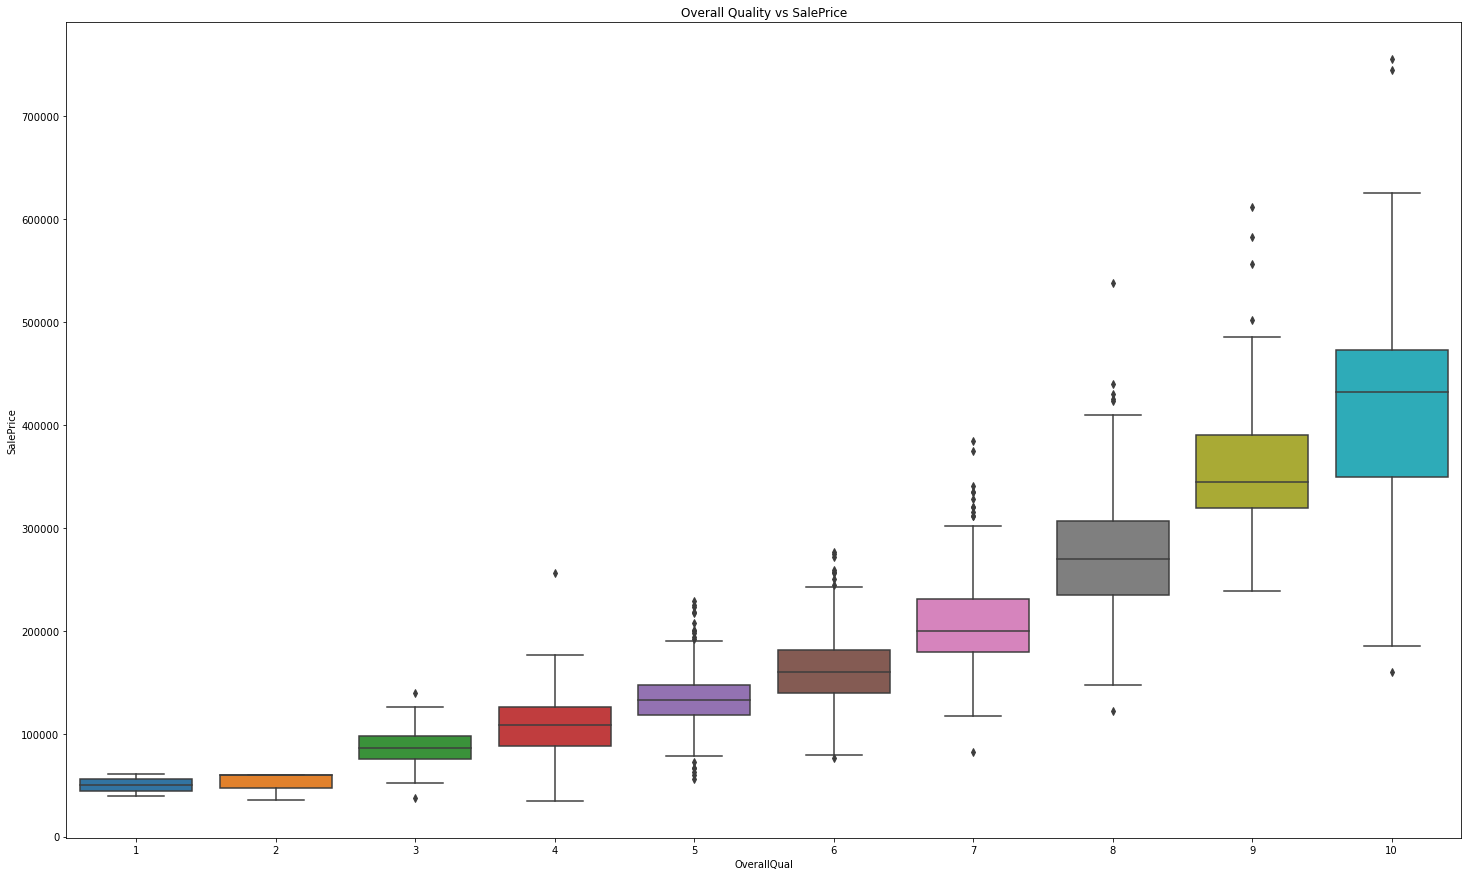

In [9]:
#OverallQuality vs SalePrice
#Since the variable tells the range from which the SalePrice varies on the basis of the Quality of the house
plt.figure(figsize = (25,15))
sns.boxplot(data = hp_tr, x="OverallQual", y = "SalePrice")
plt.title("Overall Quality vs SalePrice")
plt.show()

In [10]:
hp_tr.YearBuilt.describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

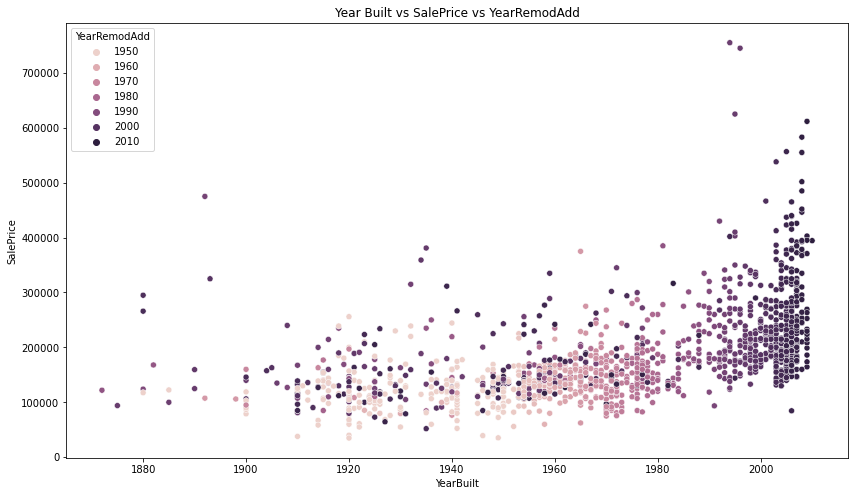

In [11]:
#Year Built and Year Re Modified have similar kind of a correlation hence would add a hue for YearRemodAdd
plt.figure(figsize = (14,8))
sns.scatterplot(x="YearBuilt", y="SalePrice",hue = "YearRemodAdd", data=hp_tr)
plt.title("Year Built vs SalePrice vs YearRemodAdd")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

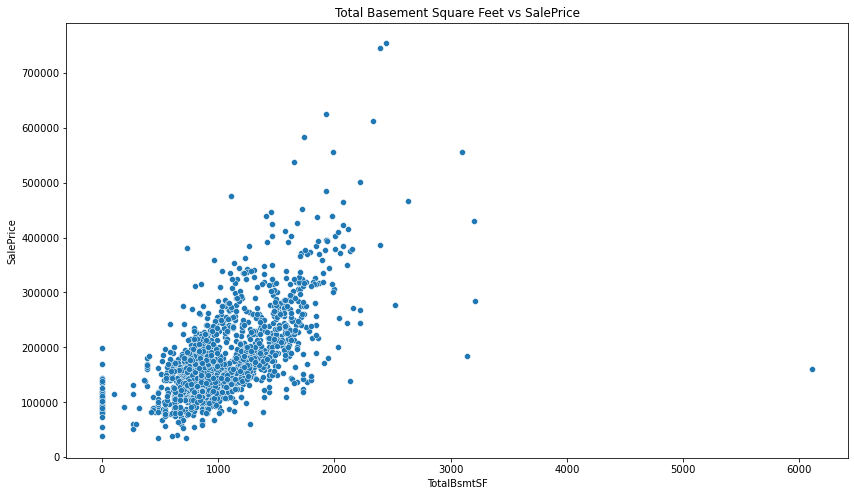

In [12]:
#Total Basement Square Feet vs SalePrice
plt.figure(figsize = (14,8))
sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=hp_tr)
plt.title("Total Basement Square Feet vs SalePrice")
plt.show

> Looking at the above scatter plot, we can see that there are some data discrepancies like an outlier somewhere around 6300 SQ Ft mark

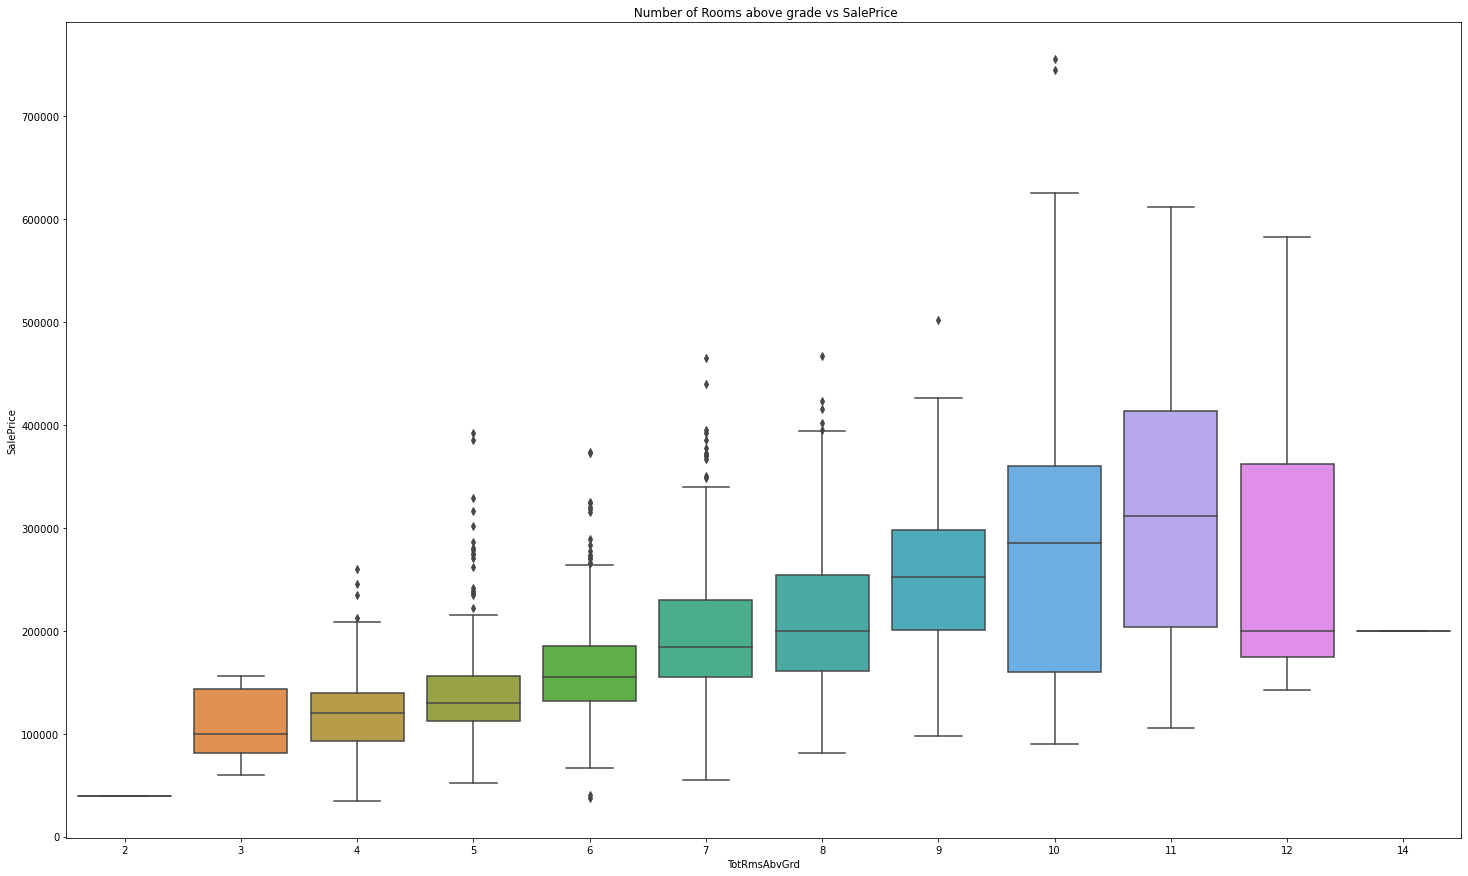

In [13]:
#TotRmsAbvGrd vs SalePrice
#Validating the relation between SalePrice and Number of Rooms above grade

#hp_tr.TotRmsAbvGrd.describe()
plt.figure(figsize = (25,15))
sns.boxplot(data = hp_tr, x="TotRmsAbvGrd", y = "SalePrice")
plt.title(" Number of Rooms above grade vs SalePrice")
plt.show()

In [14]:
hp_tr.loc[hp_tr['TotRmsAbvGrd'].isin([2,14])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


> Here, we can see that the houses with about 10 rooms have the highest range of selling price as compared to any other count, however we can still see that the mean for the houses with 11 rooms is more than 10.

> Also, we observe that there is a discrepancy in houses with 14 or 2 rooms, we need to rectify that in the data wrangling process

<function matplotlib.pyplot.show(close=None, block=None)>

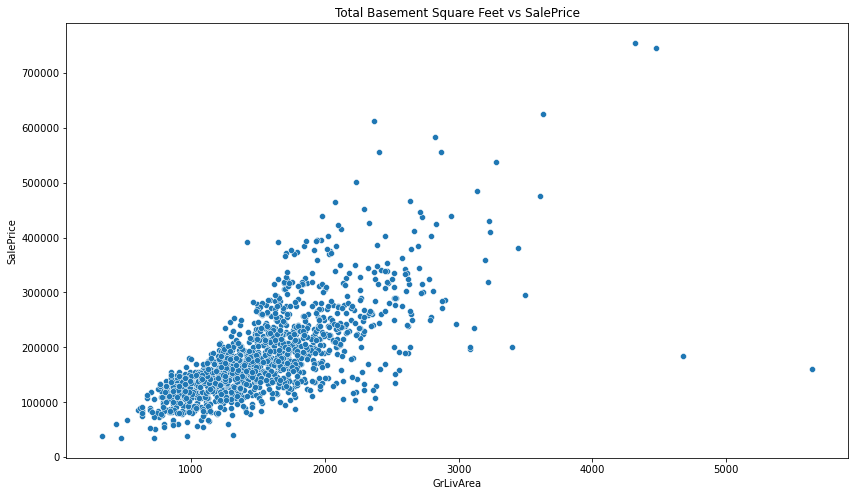

In [15]:
#GrLivArea vs SalePrice
plt.figure(figsize = (14,8))
sns.scatterplot(x="GrLivArea", y="SalePrice", data=hp_tr)
plt.title("Total Basement Square Feet vs SalePrice")
plt.show

### Data Wrangling Process
#### We would now work on processing the missing data and cleaning the data

> Here, we would join the test data with the train data, clean and wrangle it and then separate it out

In [16]:
dependent = hp_tr['SalePrice']
test_id = hp_te['Id']
hp_te = hp_te.drop(['Id'], axis = 1)
hp_tr_cl = hp_tr.drop(['Id', 'SalePrice'], axis=1)

In [17]:
#We concatenate the test and the train data after backing up SalePrice column from train as it is not present in the test data
hp_tr_te = pd.concat([hp_tr_cl, hp_te], axis = 0, sort = False)

In [18]:
hp_tr_te.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [19]:
#Checking NAN/Null values in data and creating a dataframe for future reference
null_v = pd.DataFrame(hp_tr_te.isna().sum(),columns = ['Nan_Sum'])
null_v['Perc%'] = (null_v['Nan_Sum']/len(hp_tr_te))*100
null_v = null_v[null_v['Nan_Sum'] > 0]
null_v = null_v.sort_values(by = ['Nan_Sum'])
null_v['Disc_Keep'] = np.where(null_v['Perc%']>30,'Discard', 'Keep')
null_v['DataType'] = hp_tr_te.dtypes
null_v

,Nan_Sum,Perc%,Disc_Keep,DataType
TotalBsmtSF,1,0.034258,Keep,float64
GarageArea,1,0.034258,Keep,float64
GarageCars,1,0.034258,Keep,float64
KitchenQual,1,0.034258,Keep,object
Electrical,1,0.034258,Keep,object
BsmtUnfSF,1,0.034258,Keep,float64
BsmtFinSF2,1,0.034258,Keep,float64
BsmtFinSF1,1,0.034258,Keep,float64
SaleType,1,0.034258,Keep,object
Exterior1st,1,0.034258,Keep,object


In [20]:
null_v[null_v['DataType'] == object]

,Nan_Sum,Perc%,Disc_Keep,DataType
KitchenQual,1,0.034258,Keep,object
Electrical,1,0.034258,Keep,object
SaleType,1,0.034258,Keep,object
Exterior1st,1,0.034258,Keep,object
Exterior2nd,1,0.034258,Keep,object
Functional,2,0.068517,Keep,object
Utilities,2,0.068517,Keep,object
MSZoning,4,0.137033,Keep,object
MasVnrType,24,0.822199,Keep,object
BsmtFinType1,79,2.706406,Keep,object


> We now fill the missing values of all the text variables with their modes or the average values

> We are not using any imputations here as we would be doing them for the numeric/floating point variables

In [21]:
#As an assumption, we fill the NA values for the qualitative variables to the Mode(value that occurs the most)
hp_tr_te['KitchenQual']  = hp_tr_te['KitchenQual'].fillna('TA')
hp_tr_te['Electrical'] = hp_tr_te['Electrical'].fillna(hp_tr_te['Electrical'].mode()[0])
hp_tr_te['SaleType'] = hp_tr_te['SaleType'].fillna(hp_tr_te['SaleType'].mode()[0])
hp_tr_te['Exterior1st'] = hp_tr_te['Exterior1st'].fillna(hp_tr_te['Exterior1st'].mode()[0])
hp_tr_te['Exterior2nd'] = hp_tr_te['Exterior2nd'].fillna(hp_tr_te['Exterior2nd'].mode()[0])
hp_tr_te['Functional'] = hp_tr_te['Functional'].fillna(hp_tr_te['Functional'].mode()[0])
hp_tr_te['Utilities'] = hp_tr_te['Utilities'].fillna(hp_tr_te['Utilities'].mode()[0])
hp_tr_te['MSZoning'] = hp_tr_te['MSZoning'].fillna(hp_tr_te['MSZoning'].mode()[0])

#For the variables that have significantly high missing values, on the basis of the data description file, we can say that these houses won't have such features and hence have NA as the value. We would replace them with None
for col in ['MasVnrType','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','FireplaceQu','Fence','Alley','MiscFeature','PoolQC','BsmtQual','BsmtExposure','BsmtCond','BsmtFinType1','BsmtFinType2']:
    hp_tr_te[col] = hp_tr_te[col].fillna('None')
    

In [22]:
#To Handle missing values in the numeric variables, we would use multiple imputations
from sklearn.impute import KNNImputer
ttn = hp_tr_te.select_dtypes(include=[np.number])
ttc = hp_tr_te.select_dtypes(exclude=[np.number])
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
ttn = pd.DataFrame(imputer.fit_transform(ttn),columns = ttn.columns)

#Reset ttc index
ttc = ttc.reset_index(drop=True)

#Concatenate TTN & TTC
hp_tr_te = pd.concat([ttn,ttc],axis=1)

In [23]:
hp_tr_te.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [24]:
max(hp_tr_te.isna().sum())

0

> Data is now clean and has all the missing values imputed with estimated data using KNN Imputations

### Feature Engineering

In [25]:
#Created 3 features that I find are one of the most important as a combination
hp_tr_te['TotalSquareFeetArea'] = hp_tr_te['GrLivArea']+hp_tr_te['1stFlrSF']+hp_tr_te['2ndFlrSF']+hp_tr_te['TotalBsmtSF']
hp_tr_te['Total_Home_Quality'] = hp_tr_te['OverallQual'] + hp_tr_te['OverallCond']
hp_tr_te['Total_Bathrooms'] = (hp_tr_te['FullBath'] + (0.5 * hp_tr_te['HalfBath']) +
                               hp_tr_te['BsmtFullBath'] + (0.5 * hp_tr_te['BsmtHalfBath']))

#Dummy Variable creation
hp_tr_te_dum = pd.get_dummies(hp_tr_te)

#Separate out the numeric variables to check the skewness and apply logarithmic transformation to correct the skewness
from scipy.stats import skew
hp_tr_te_num = hp_tr_te_dum.dtypes[hp_tr_te_dum.dtypes != object].index
skewed_features = hp_tr_te_dum[hp_tr_te_num].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
    
for i in skew_index:
    hp_tr_te_dum[i] = np.log1p(hp_tr_te_dum[i])


> As per the EDA, we saw that the SalePrice was skewed heavily towards the right

> We need to transform it using the logarithmic transformation to correct the skew

/Users/apple/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


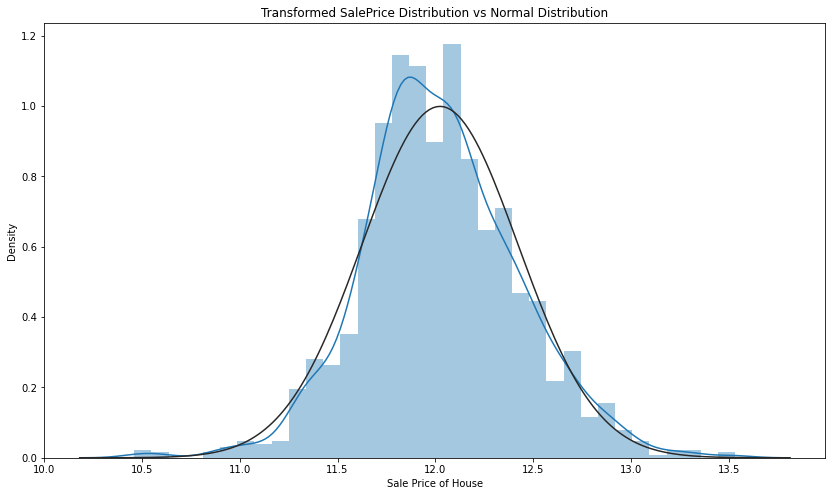

In [26]:
dependent_log = np.log1p(dependent)
plt.figure(figsize = (14,8))
sns.distplot(dependent_log, kde= True, hist=True, fit = norm)
plt.xlabel('Sale Price of House')
plt.title('Transformed SalePrice Distribution vs Normal Distribution')
plt.show()

### Modelling Process
> Here we start the various modelling techniques and check which of the predictive models, LASSO or Ridge regression work the best to predict the house prices

> Since we merged the test and train initially, we would now separate them and perform the model training process on the training data and test it on test data

In [27]:
#Split Train and test data
training_data = hp_tr_te_dum[:1460]
testing_data = hp_tr_te_dum[1460:]
testing_data.reset_index(drop=True)
#testing_data['Id'] = range(1460, 1460+len(testing_data))

#Splitting training data into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(training_data, dependent_log, test_size=0.25, random_state=42)

In [29]:
#LASSO

from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
alphas = [0.1,0.3, 0.5, 0.8, 1]
lassocv = LassoCV(alphas=alphas, cv=5, verbose=True).fit(X_train,Y_train)
print(lassocv) 

score = lassocv.score(X_train,Y_train)
ypred = lassocv.predict(X_val)
mse = mean_squared_error(Y_val,ypred)

print("Alpha:{0:.2f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(lassocv.alpha_, score, mse, np.sqrt(mse)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.........................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


LassoCV(alphas=[0.1, 0.3, 0.5, 0.8, 1], cv=5, verbose=True)
Alpha:0.10, R2:0.694, MSE:0.06, RMSE:0.23


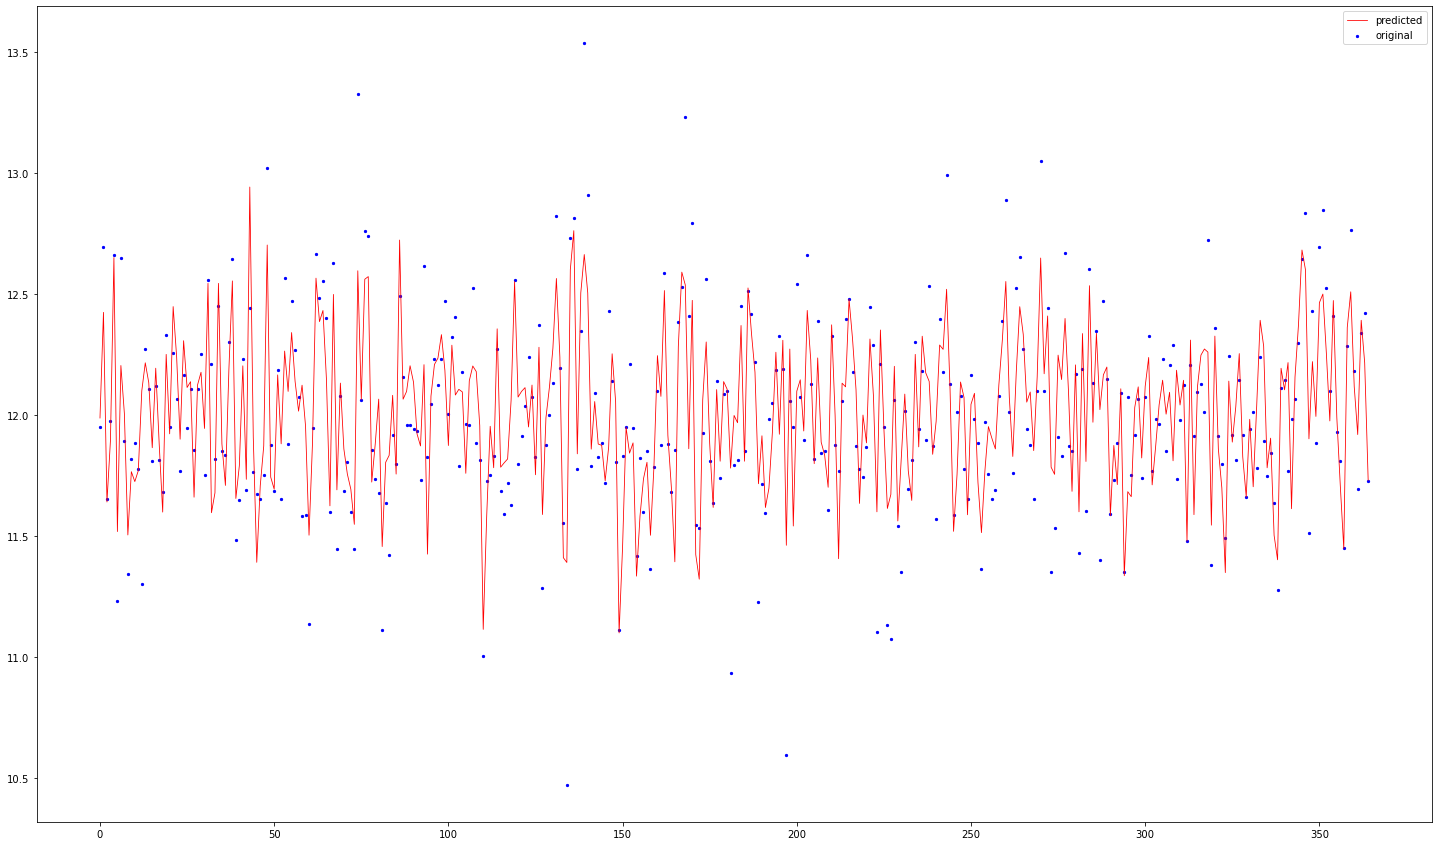

In [30]:
#Plot the Lasso Cross Validation graph

x_ax = range(len(X_val))
plt.figure(figsize = (25,15))
plt.scatter(x_ax, Y_val, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

In [31]:
test_pred = lassocv.predict(testing_data)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

,Id,SalePrice
0,1461,173550.635237
1,1462,131150.080571
2,1463,180663.983384
3,1464,196137.586033
4,1465,197535.928505


In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, Y_train, scoring = "neg_mean_squared_error",cv = 5))
    return(rmse)

ridge = RidgeCV(alphas = np.arange(0.01,1,0.01)).fit(X_train, Y_train)
print(rmse_cv(ridge).mean())

0.13932987948407544


In [34]:
#Ridge Regression
model = Ridge(alpha=0.14)
model.fit(X_train, Y_train)

score = model.score(X_train,Y_train)
print(score)
ypred = model.predict(X_val)
print(ypred)
mse = mean_squared_error(Y_val,ypred)
print(mse)

0.9482408994311723
[11.94723465 12.72577942 11.54679201 12.05697818 12.70270112 11.23724582
 12.44183224 11.90418343 11.20283096 11.88057784 11.88572373 11.6129859
 11.39024281 12.22720557 12.05825108 11.79340894 12.15383454 11.76223769
 11.60446416 12.27853811 11.93136143 12.23185146 12.07824761 11.76024572
 12.20763549 11.94774571 12.16131866 11.62613878 12.09882191 12.25395191
 11.947693   12.51071745 12.14917213 11.6821228  12.44916677 11.89334576
 11.82338363 12.22518714 12.69393182 11.5877424  11.74229145 12.28781732
 11.61653977 12.7850722  11.75621143 11.81430048 11.55589179 11.78810514
 12.9963465  11.8525233  11.68823854 12.25467734 11.59420033 12.52157073
 11.96134651 12.39464423 12.21604327 11.98585628 11.75059427 11.41643547
 11.05301248 12.02144703 12.62561926 12.43235049 12.63156636 12.24609235
 11.60992773 12.6188483  11.81670256 12.07052498 11.73258085 11.75544017
 11.62619727 11.24772934 13.0141635  12.0529455  12.61127401 12.63588917
 11.9113124  11.67733553 11.61924

In [35]:
test_pred = model.predict(testing_data)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
print(submission.head())

     Id      SalePrice
0  1461  123978.338057
1  1462  153032.595274
2  1463  188691.319870
3  1464  196671.292617
4  1465  202918.393089


In [ ]:
# submission.to_csv("result_ridge.csv", index = False, header = True)